# Analyse campagnes marketing client
Dans ce Notebook, nous retrouverez l'ensemble des analyses exploratoires, modèles prédictifs et clusterings client effectués pour justifier notre chiffrage de
l’efficacité des campagnes marketing et cerner la cible client du magasin.

Pour faire fonctionner ce Notebook, nous devons au préalable importer certaines bibliothèques Python :

In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import datetime

from matplotlib import rcParams
from matplotlib.cbook import boxplot_stats
from datetime import date
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

Avant de pouvoir analyser notre jeu de données, nous devons d'abord le récupérer dans le fichier .csv "Camp_Market" :

In [84]:
df = pd.read_csv("Camp_Market.csv", sep=';')

## 1 - Nettoyage et organisation des données

Pour commencer, nous avons nettoyé les données pour comprendre leur structure et les informations qu'elles contiennent. Certaines colonnes de notre jeu de données contiennent des variables catégorielles, comme c'est le cas pour `Education`. Afin d'effectuer notre analyse exploratoire, nous avons besoin de convertir ces variables catégorielles en valeurs numériques.

Dans cette optique, nous avons restructuré notre jeu de données : grâce au One-Hot, nous avons pu convertir nos valeurs catégorielles en valeurs numériques dans le but de faciliter l'analyse.

In [85]:
# Encodage One-Hot
data_encoded = pd.get_dummies(df, columns=['Education'])

Nous avons ensuite créé huit nouvelles colonnes numériques contenant les nouvelles valeurs :

In [86]:
#var Living_with
def love_status(status):
    if status == "Single" or status == "Widow" or status == "Divorced":
        return 'Single'
    elif status == "Together" or status == "Married":
        return 'In a relationship'
data_encoded["Living_with"] = df["Marital_Status"].apply(love_status)

#var Family_size
data_encoded["Family_size"] = data_encoded["Kidhome"] + data_encoded["Teenhome"] + np.where(
    (data_encoded["Marital_Status"] == "Together") | (data_encoded["Marital_Status"] == "Married"), 
    2, 
    1
)

# var Customer_for nombre de jours depuis que le client a commencé ses achats au magasin depuis la dernière date enregistrée
today = pd.Timestamp(datetime.date.today())
data_encoded["Customer_for"] = (today - pd.to_datetime(df["Dt_Customer"])).dt.days

# var Age
data_encoded["Age"] = date.today().year - data_encoded["Year_Birth"]

#var Spend
data_encoded["Spent"] = data_encoded[[col for col in df.columns if col.startswith('Mnt')]].sum(axis=1)

#var Is_parent
data_encoded["Is_parent"] = np.where((data_encoded["Kidhome"] > 0) | (data_encoded["Teenhome"] > 0), 1, 0)

#var Children
data_encoded["Children"] = data_encoded.Kidhome + data_encoded.Teenhome

#var Education
def edu_level(level):
    if (level == "Master" or level == "Phd") :
        return 2
    elif(level == "Graduation") :
        return 1
    else :
        return 0

#var Marital_Status_Score
data_encoded["Marital_Status_Score"] = data_encoded["Marital_Status"].map({
    "Alone" :1,
    "Single": 2,
    "Together": 3,
    "Married": 4,
    "Divorced": 5,
    "Widow": 6,
})
data_encoded["Education2"] = df["Education"].apply(edu_level)

Maintenant que l'on a les colonnes qui nous intéressent, nous supprimons les colonnes contenant des valeurs vides et les colonnes non utilisées :

In [87]:
dropped_columns = ["Dt_Customer", "Dt_Customer", "Marital_Status", "Year_Birth", "Kidhome", "Teenhome", "Living_with", "Education_Master", "Education_PhD", "Education_Graduation", "Education_Basic", "Education_2n Cycle"]
data_encoded = data_encoded.drop(dropped_columns, axis=1)
data_encoded = data_encoded.dropna()
data_encoded.head()

,ID,Income,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,...,Z_Revenue,Response,Family_size,Customer_for,Age,Spent,Is_parent,Children,Marital_Status_Score,Education2
0,5524,58138.0,58,635,88,546,172,88,88,3,...,11,1,1,4054,66,1617,0,0,2.0,1
1,2174,46344.0,38,11,1,6,2,1,6,2,...,11,0,3,3504,69,27,1,2,2.0,1
2,4141,71613.0,26,426,49,127,111,21,42,1,...,11,0,2,3703,58,776,0,0,3.0,1
3,6182,26646.0,26,11,4,20,10,3,5,2,...,11,0,3,3530,39,53,1,1,3.0,1
4,5324,58293.0,94,173,43,118,46,27,15,5,...,11,0,3,3552,42,422,1,1,4.0,0


Enfin, on observe la répartition des données de chaque colonne autour de leurs médianes respectives afin de déterminer les valeurs aberrantes :

Text(0.5, 1.0, 'Graphique de répartition des valeurs par colonne')

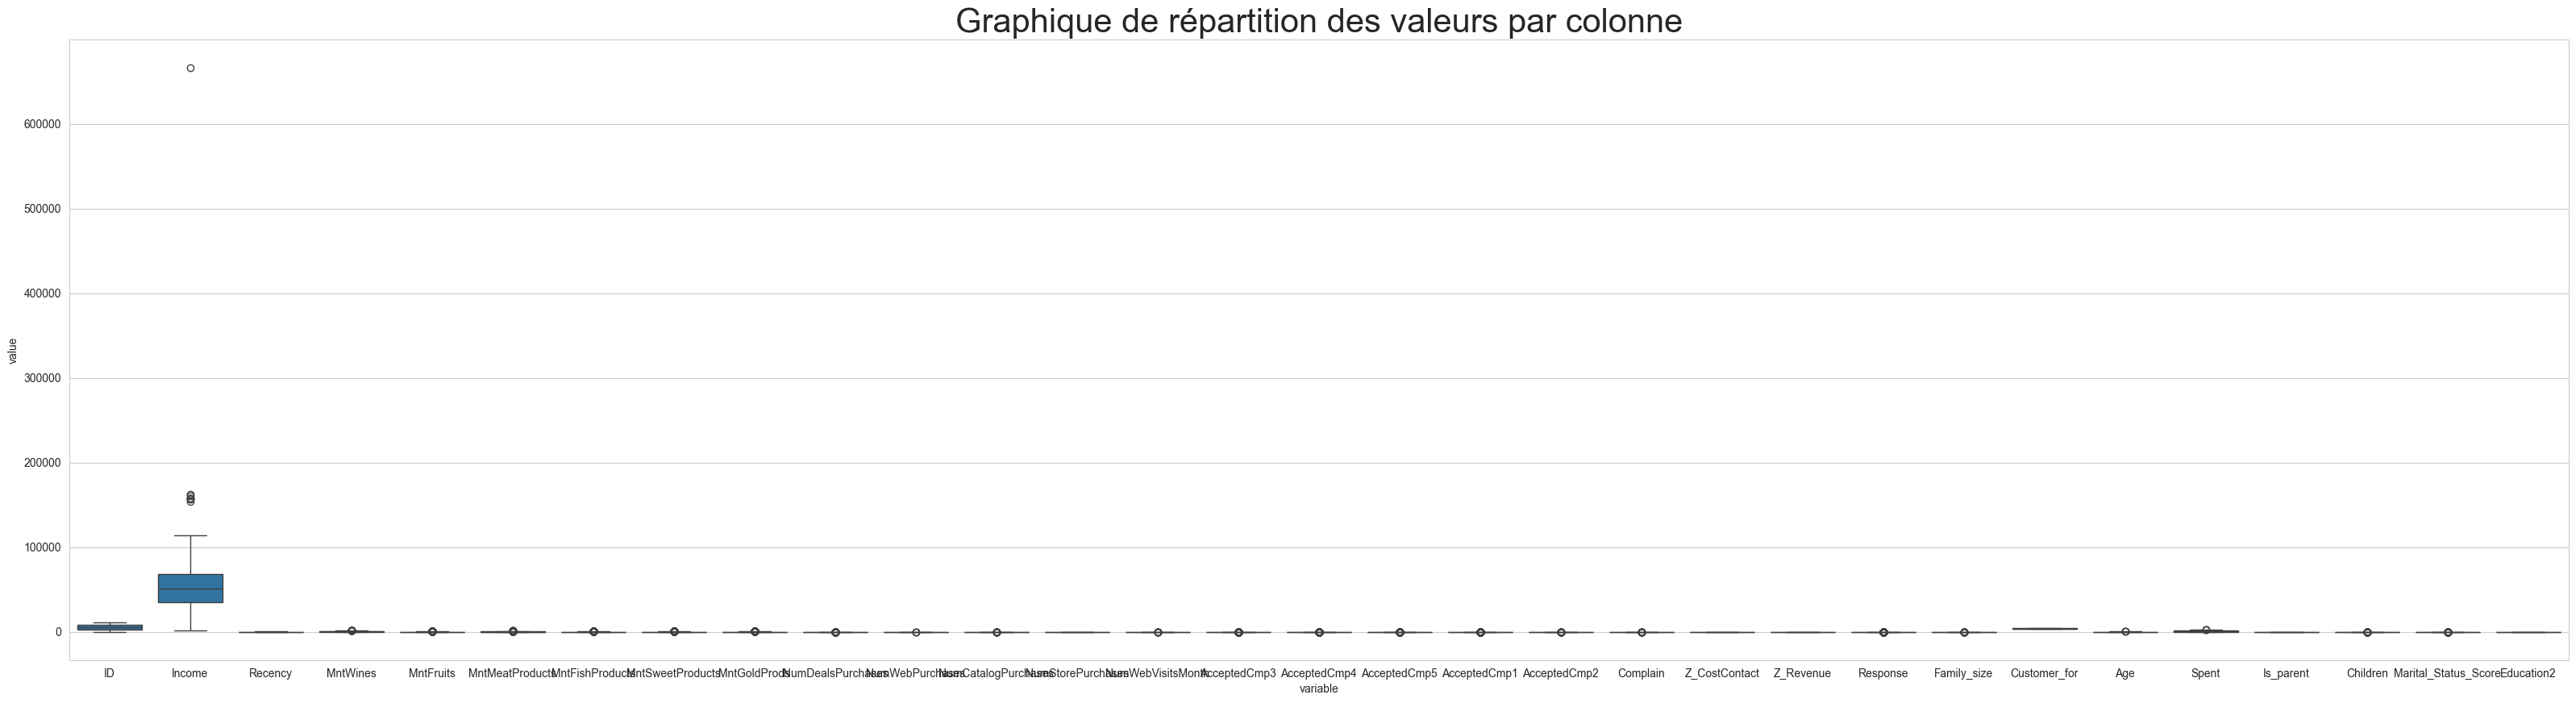

In [88]:
sns.boxplot(x='variable', y='value', data=pd.melt(data_encoded))
plt.title("Graphique de répartition des valeurs par colonne", fontsize=30)

Après observation des graphiques en boîte à moustaches, la catégorie `Income` (revenus) possède les valeurs aberrantes les plus prononcées. On observe aussi que la plupart des colonnes possèdent des valeurs aberrantes dans le jeu : 

Text(0.5, 1.0, "Graphique de répartition des valeurs par colonne sans 'Income'")

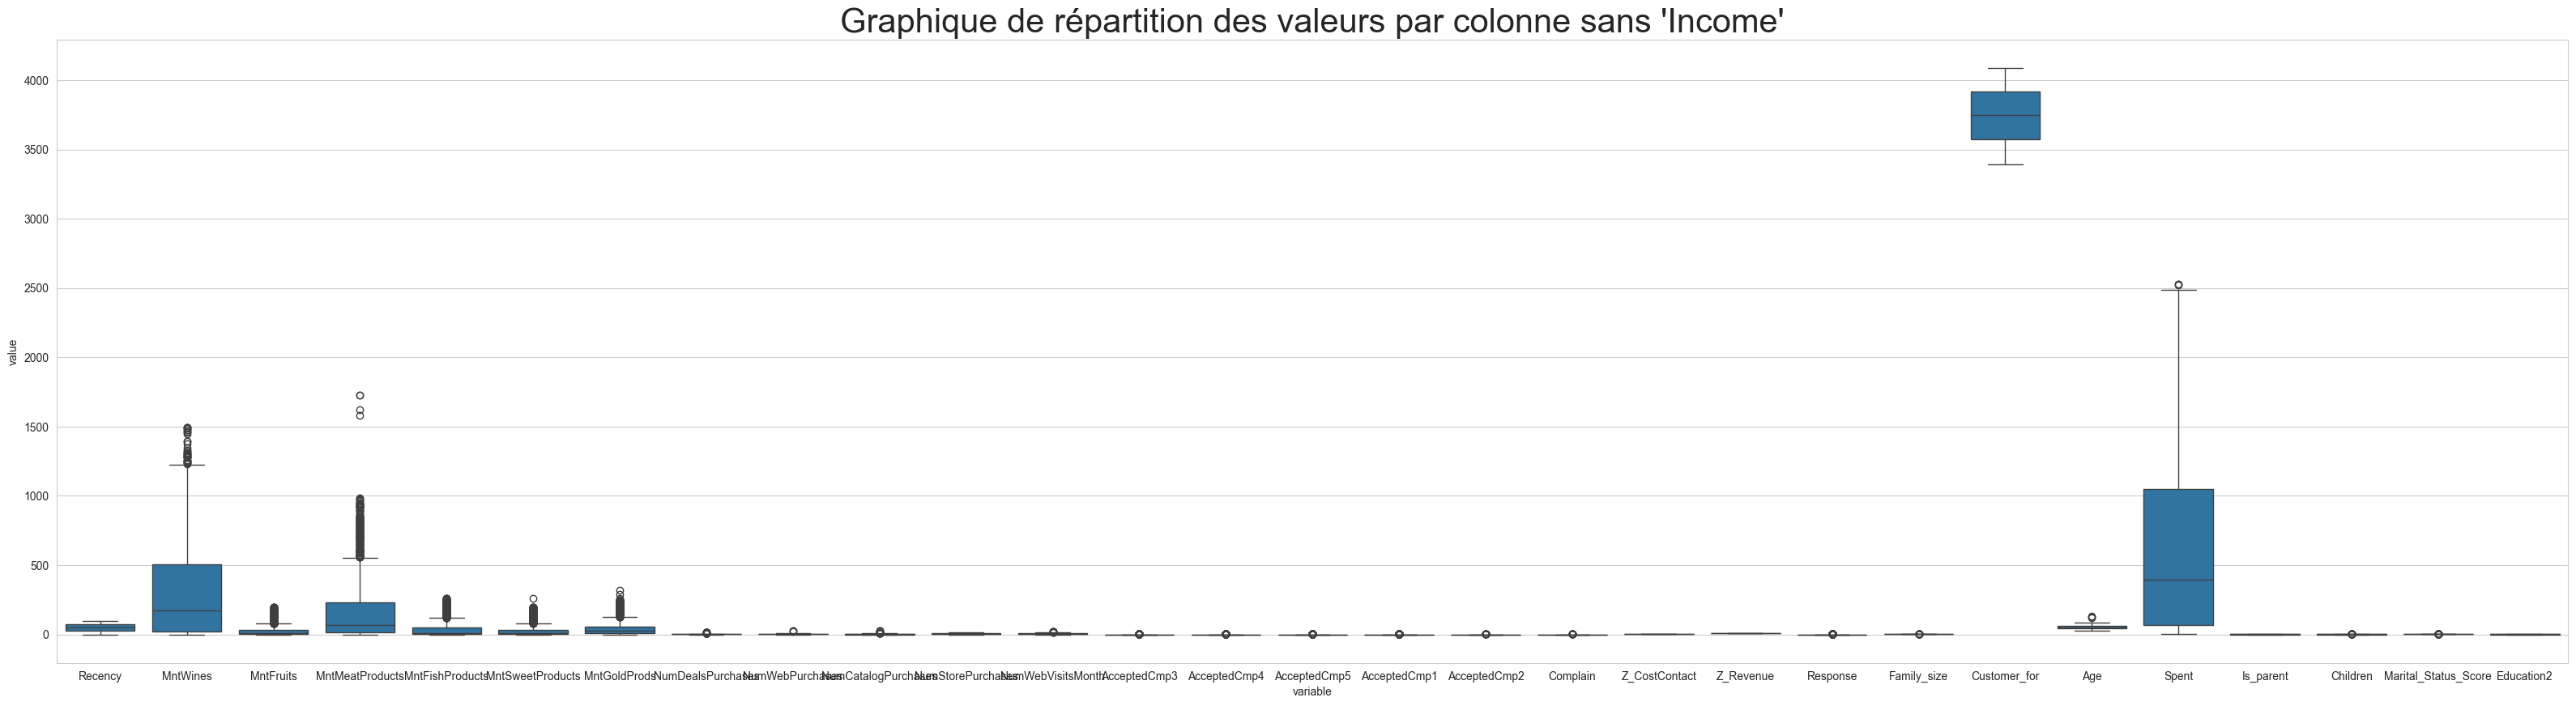

In [89]:
# Code
rcParams['figure.figsize'] = 40, 10
sns.boxplot(x='variable', y='value', data=pd.melt(data_encoded.drop(columns=["Income", "ID"])))
plt.title("Graphique de répartition des valeurs par colonne sans 'Income'", fontsize=30)

Cependant, seules les valeurs de la catégorie `Income` sont assez significatives pour réellement influencer les résultats d'analyse. Nous avons donc récupéré ces valeurs, afin de les exclure par la suite de notre jeu de données : 

Text(0.5, 1.0, 'Graphique de répartition des valeurs par colonne sans valeurs aberrantes')

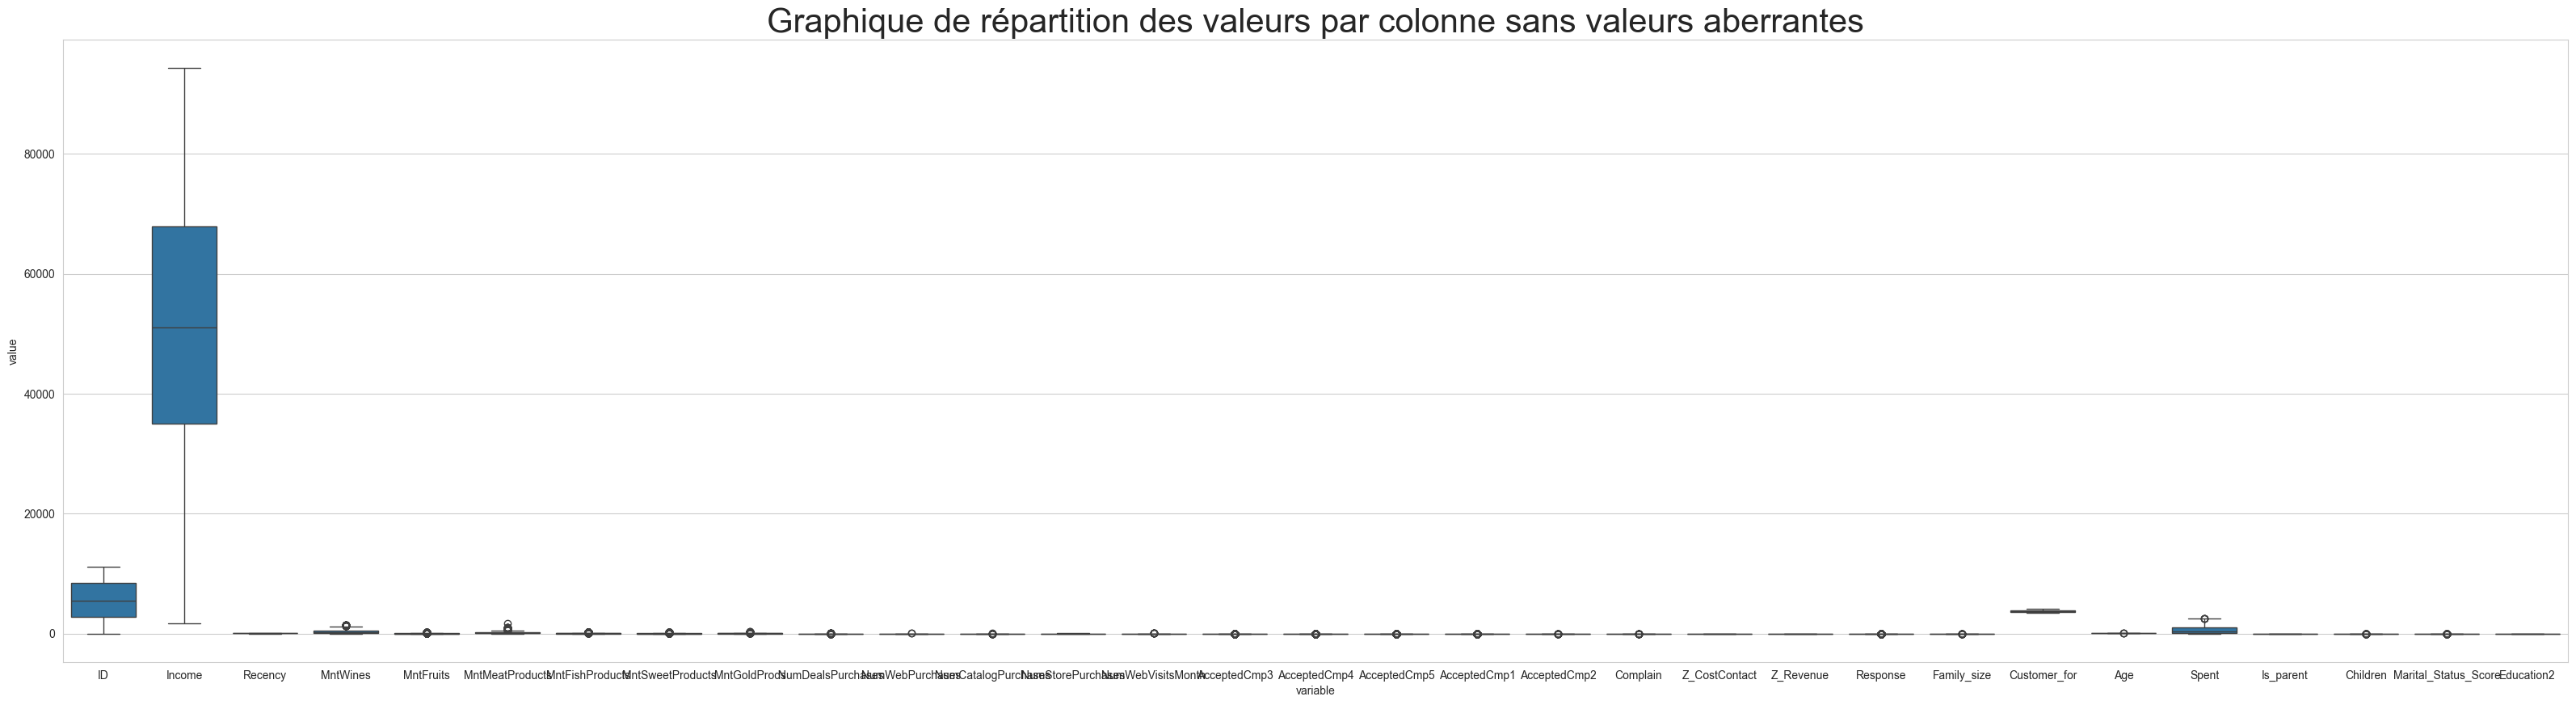

In [90]:
# Code
q_hi  = df["Income"].quantile(0.99)

data_encoded = data_encoded[data_encoded["Income"] < q_hi]
sns.boxplot(x='variable', y='value', data=pd.melt(data_encoded))
plt.title("Graphique de répartition des valeurs par colonne sans valeurs aberrantes", fontsize=30)

Pour finir ce nettoyage, nous devons gérer le cas des valeurs constantes ainsi que non présentes.

En outre, 1.07% des valeurs de la colonne `Income` a des valeurs manquantes. Étant donné que ce pourcentage est assez faible, nous avons choisi de supprimer ces lignes. De plus, les colonnes `Z_CostContact` et `Z_Revenue` sont constantes, ce qui veut dire qu'elles possèdent la même valeur pour tous les clients. Elles ne seront donc pas utiles pour notre analyse et ont été supprimées :

In [91]:
# Code
data_encoded = data_encoded.drop(columns=["Z_CostContact", "Z_Revenue"]);
data_encoded.head()

,ID,Income,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,...,Complain,Response,Family_size,Customer_for,Age,Spent,Is_parent,Children,Marital_Status_Score,Education2
0,5524,58138.0,58,635,88,546,172,88,88,3,...,0,1,1,4054,66,1617,0,0,2.0,1
1,2174,46344.0,38,11,1,6,2,1,6,2,...,0,0,3,3504,69,27,1,2,2.0,1
2,4141,71613.0,26,426,49,127,111,21,42,1,...,0,0,2,3703,58,776,0,0,3.0,1
3,6182,26646.0,26,11,4,20,10,3,5,2,...,0,0,3,3530,39,53,1,1,3.0,1
4,5324,58293.0,94,173,43,118,46,27,15,5,...,0,0,3,3552,42,422,1,1,4.0,0


## 2 - Analyse Exploratoire

Maintenant que nos données sont nettoyées, nous avons exploré les données pour comprendre leur structure, détecter des valeurs manquantes afin de produire des outils de visualisation des distributions des différentes variables.

### A - Analyse univariée

Pour se faire, nous allons commencer par comprendre la distribution de chaque variable dans notre jeu par le biai d'un analyse univariée. Nous avons donc  exploré les distributions et les comptages de certaines variables clés.

Dans le cadre de notre magasin, nous avons retenus cinq catégories : les revenus, le nombre de jours depuis le dernier achat client, le total d'achats en ligne et en magasin, et le nombre de visites sur le site web par mois. Les graphiques suivants représentent ces distributions de variables numériques :

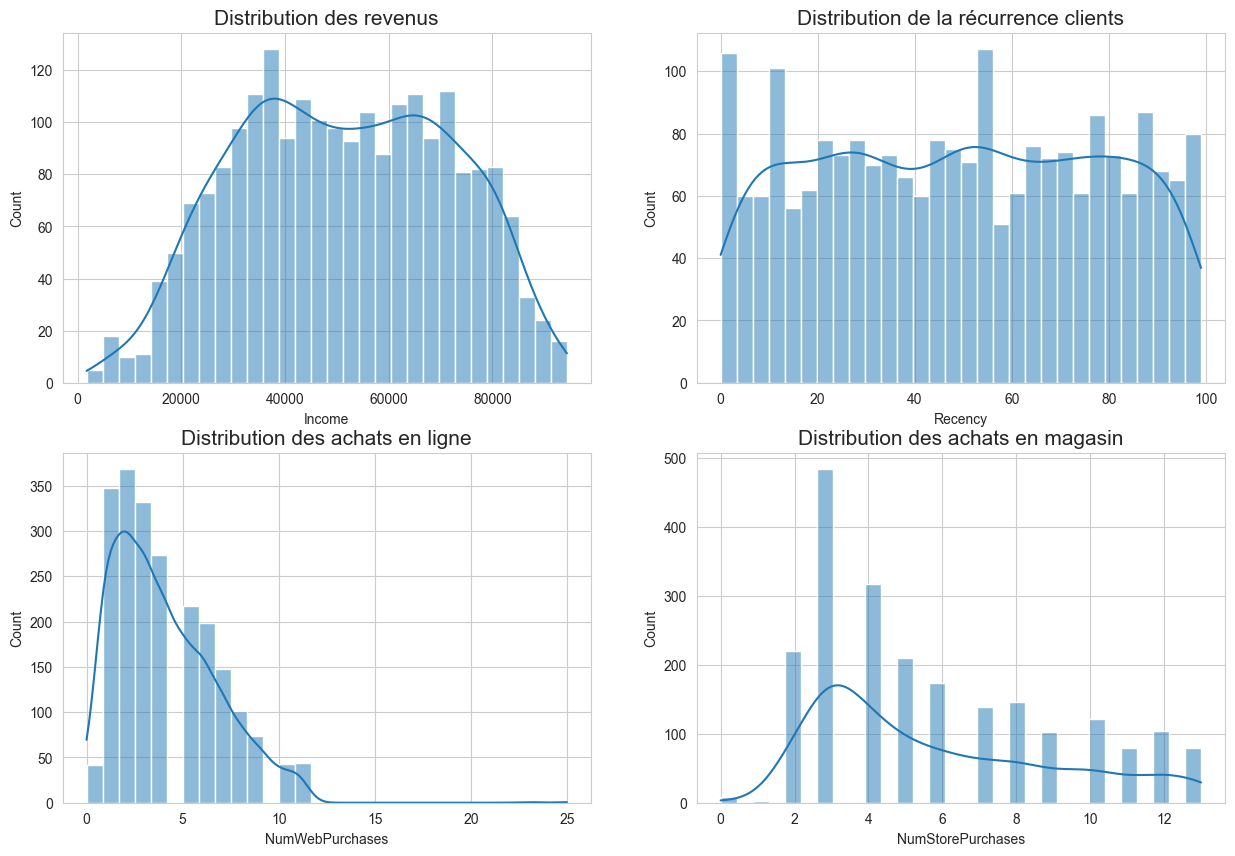

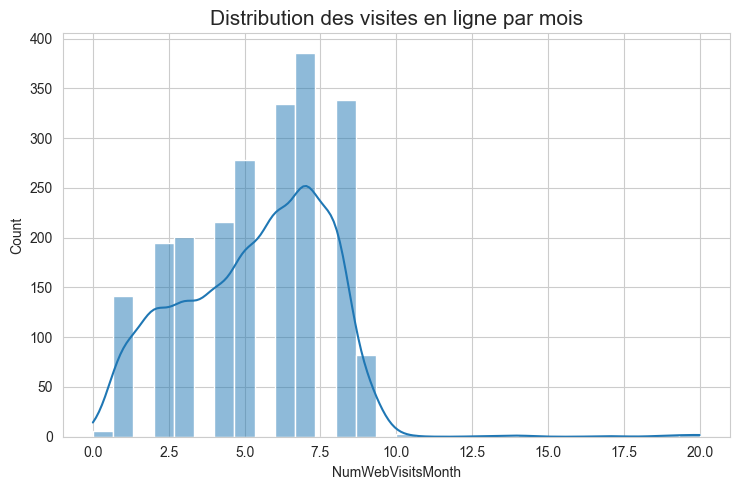

In [92]:
# Code graphiques
sns.set_style("whitegrid")
num_vars = ['Income', 'Recency', 'NumWebPurchases', 'NumStorePurchases', 'NumWebVisitsMonth']
titles = ['Distribution des revenus', 'Distribution de la récurrence clients',
          'Distribution des achats en ligne', 'Distribution des achats en magasin', 'Distribution des visites en ligne par mois']

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
for ax, var, title in zip(axes.flatten(), num_vars[:-1], titles[:-1]):
    sns.histplot(data_encoded[var], bins=30, ax=ax, kde=True)
    ax.set_title(title, fontsize=15)

fig, ax = plt.subplots(figsize=(7.5, 5))
sns.histplot(data_encoded[num_vars[-1]], bins=30, ax=ax, kde=True)
ax.set_title(titles[-1], fontsize=15)
plt.tight_layout()
plt.show()

Concernant les revenus, nous observons une distribution asymétrique positive, avec une concentration de clients dans les tranches de revenu inférieur et quelques clients dans les tranches de revenu supérieur. Il y a également un pic à 0, où nous avons imputé les valeurs manquantes.

Si on se focalise plus sur les achats, des tendances se distinguent :
- En termes de réccurence, on peut voir que la plupart des clients ont effectué un achat relativement récemment, comme le montre le pic sur le côté gauche de la distribution.
- En termes de fréquence d'achat, il est évident que la plupart de nos clients ont effectué un achat relativement récemment, comme le suggère le pic marquant à gauche de la distribution. Cette distribution nous permet de conclure que la majorité de nos clients effectuent jusqu'à 10 achats en ligne, avec un point culminant autour de 5 à 6 achats. En revanche, en ce qui concerne les achats en magasin, ces mêmes clients semblent effectuer entre 2 et 10 achats.

En ce qui concerne les visites mensuelles sur notre site Web, la distribution présente plusieurs pics distincts, suggérant que différents segments de clients visitent notre site avec des fréquences variables.

Maintenant que nous avons étudié les variables numériques, observons la répartition des variables catégorielles comme `Education` et `Marital_Status` :

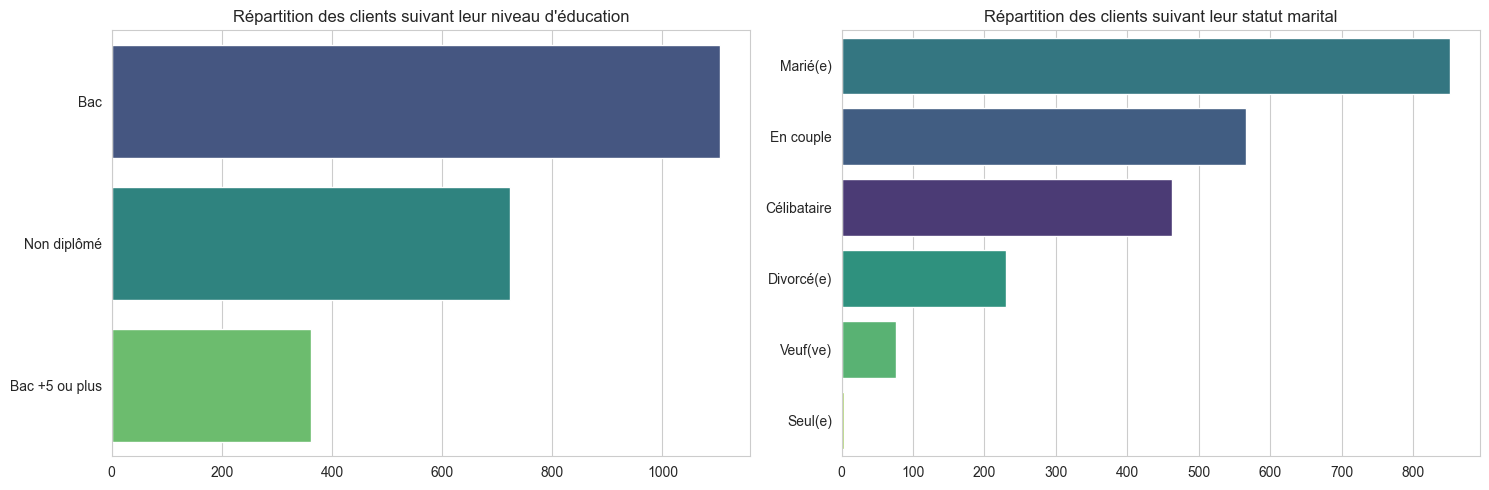

In [93]:
# Mappings
marital_status_mapping = {
    1: "Seul(e)", 2: "Célibataire", 3: "En couple", 4: "Marié(e)", 5: "Divorcé(e)", 6: "Veuf(ve)" }
education_mapping = { 0: "Non diplômé", 1: "Bac", 2: "Bac +5 ou plus" }

data_vis = data_encoded.copy()
data_vis['Marital_Status_Labels'] = data_vis['Marital_Status_Score'].map(marital_status_mapping)
data_vis['Education_Labels'] = data_vis['Education2'].map(education_mapping)

# Code graphiques
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
cat_vars = ['Education_Labels', 'Marital_Status_Labels']
titles = ["Répartition des clients suivant leur niveau d'éducation", "Répartition des clients suivant leur statut marital" ]

for ax, var, title in zip(axes.flatten(), cat_vars, titles):
    sns.countplot(y=data_vis[var], ax=ax, order=data_vis[var].value_counts().index, hue=data_vis[var], palette="viridis")
    ax.set_title(title)
    ax.set_xlabel('')
    ax.set_ylabel('')

plt.tight_layout()
plt.show()

On observe que la plupart de vos clients ont au moins le Baccalauréat, et vivent avec un partenaire. Ce sont des bons indicateurs pour établir le profil de votre client cible.

## B - Analyse bivariée

Maintenant que nous avons vu un peu plus en détails la répartition de votre clientèle et de leurs habitudes de consommation de manière linéaire, ajoutons une dimension en analysant la relation entre la variable cible `Response` et d'autres variables explicatives. Cela nous permettra de déterminer comment la réponse à la campagne est influencée par différentes variables. Nous allons tout d'abord visualiser la proportion de clients qui ont répondu positivement à la campagne par rapport à différentes variables explicatives : 

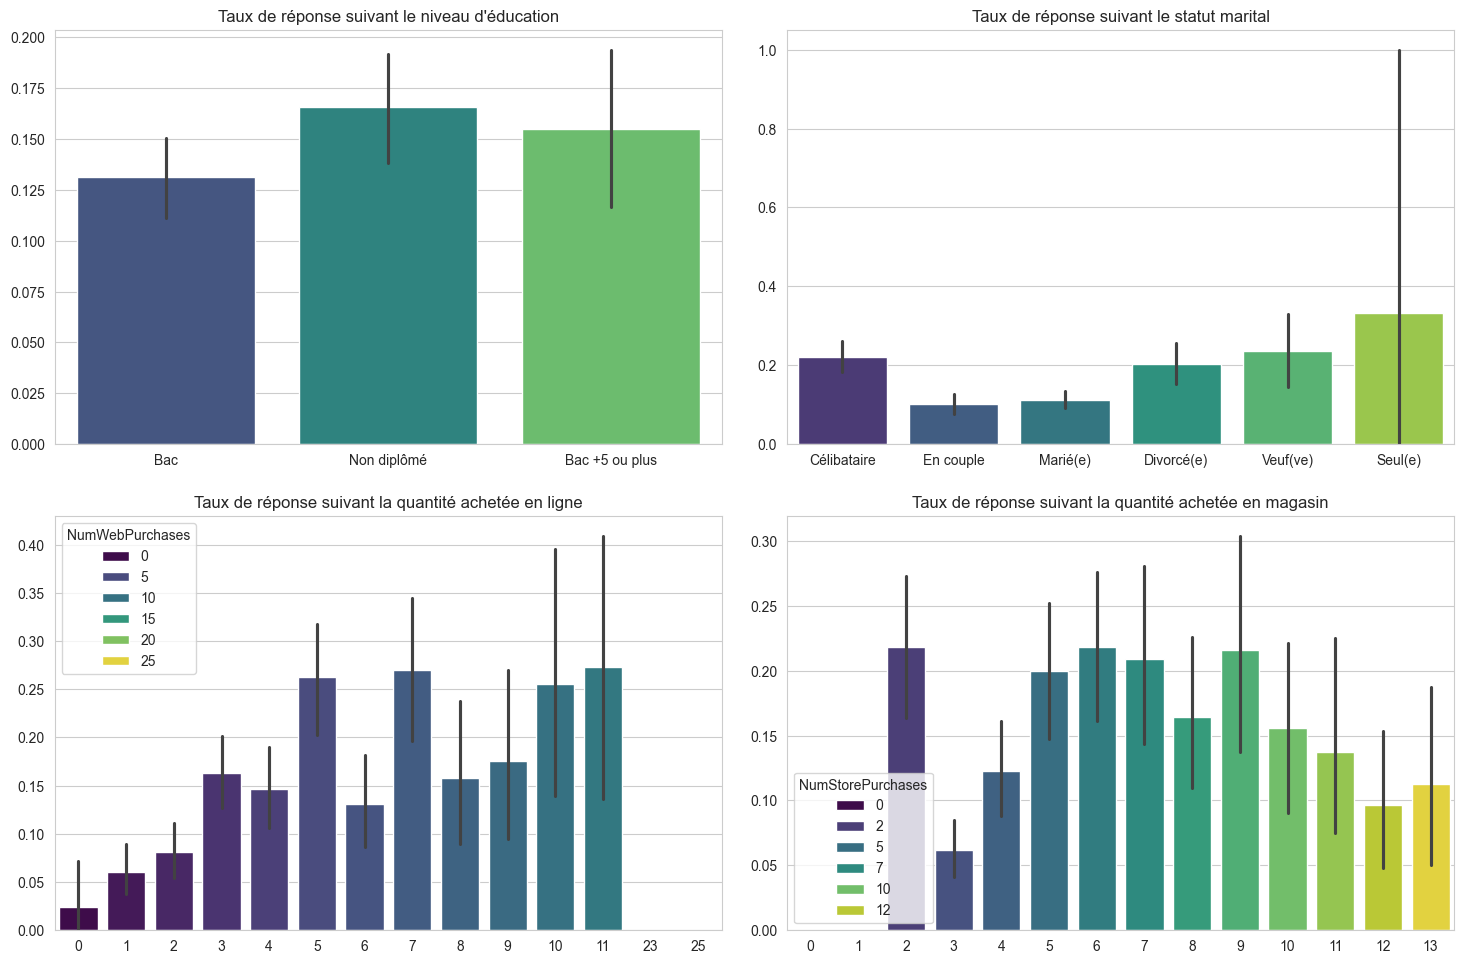

In [94]:
# Code graphiques
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
bi_vars = ['Education_Labels', 'Marital_Status_Labels', 'NumWebPurchases', 'NumStorePurchases']
titles = ["Taux de réponse suivant le niveau d'éducation", "Taux de réponse suivant le statut marital", "Taux de réponse suivant la quantité achetée en ligne", "Taux de réponse suivant la quantité achetée en magasin"]

for ax, var, title in zip(axes.flatten(), bi_vars, titles):
    sns.barplot(x=var, y='Response', data=data_vis, hue=var, ax=ax, palette="viridis")
    ax.set_title(title)
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.title.set_position([.5, 1.05])

plt.tight_layout(pad=2.0)
plt.show()

On observe que les clients avec un niveau d'éducation faible semblent avoir un taux de réponse légèrement supérieur aux autres niveaux d'éducation.
Egalement, les clients divorcés ou célibataires ont également un taux supérieur aux autres catégories. A l'inverse, il semble y avoir une tendance décroissante entre le nombre d'achats effectués en ligne et la réponse à la campagne. Cependant, il est bon de noter qu'il n'y a pas de tendance claire entre le nombre d'achats en magasin et la réponse à la campagne.

### C - Analyse multivariée

Dans le cadre de notre analyse exploratoire, nous avons réalisé une matrice de corrélation pour mettre en lumière des liens entre variables. Ce procédé a pour but d'identifier les variables qui sont fortement corrélées entre elles et avec la variable cible : 

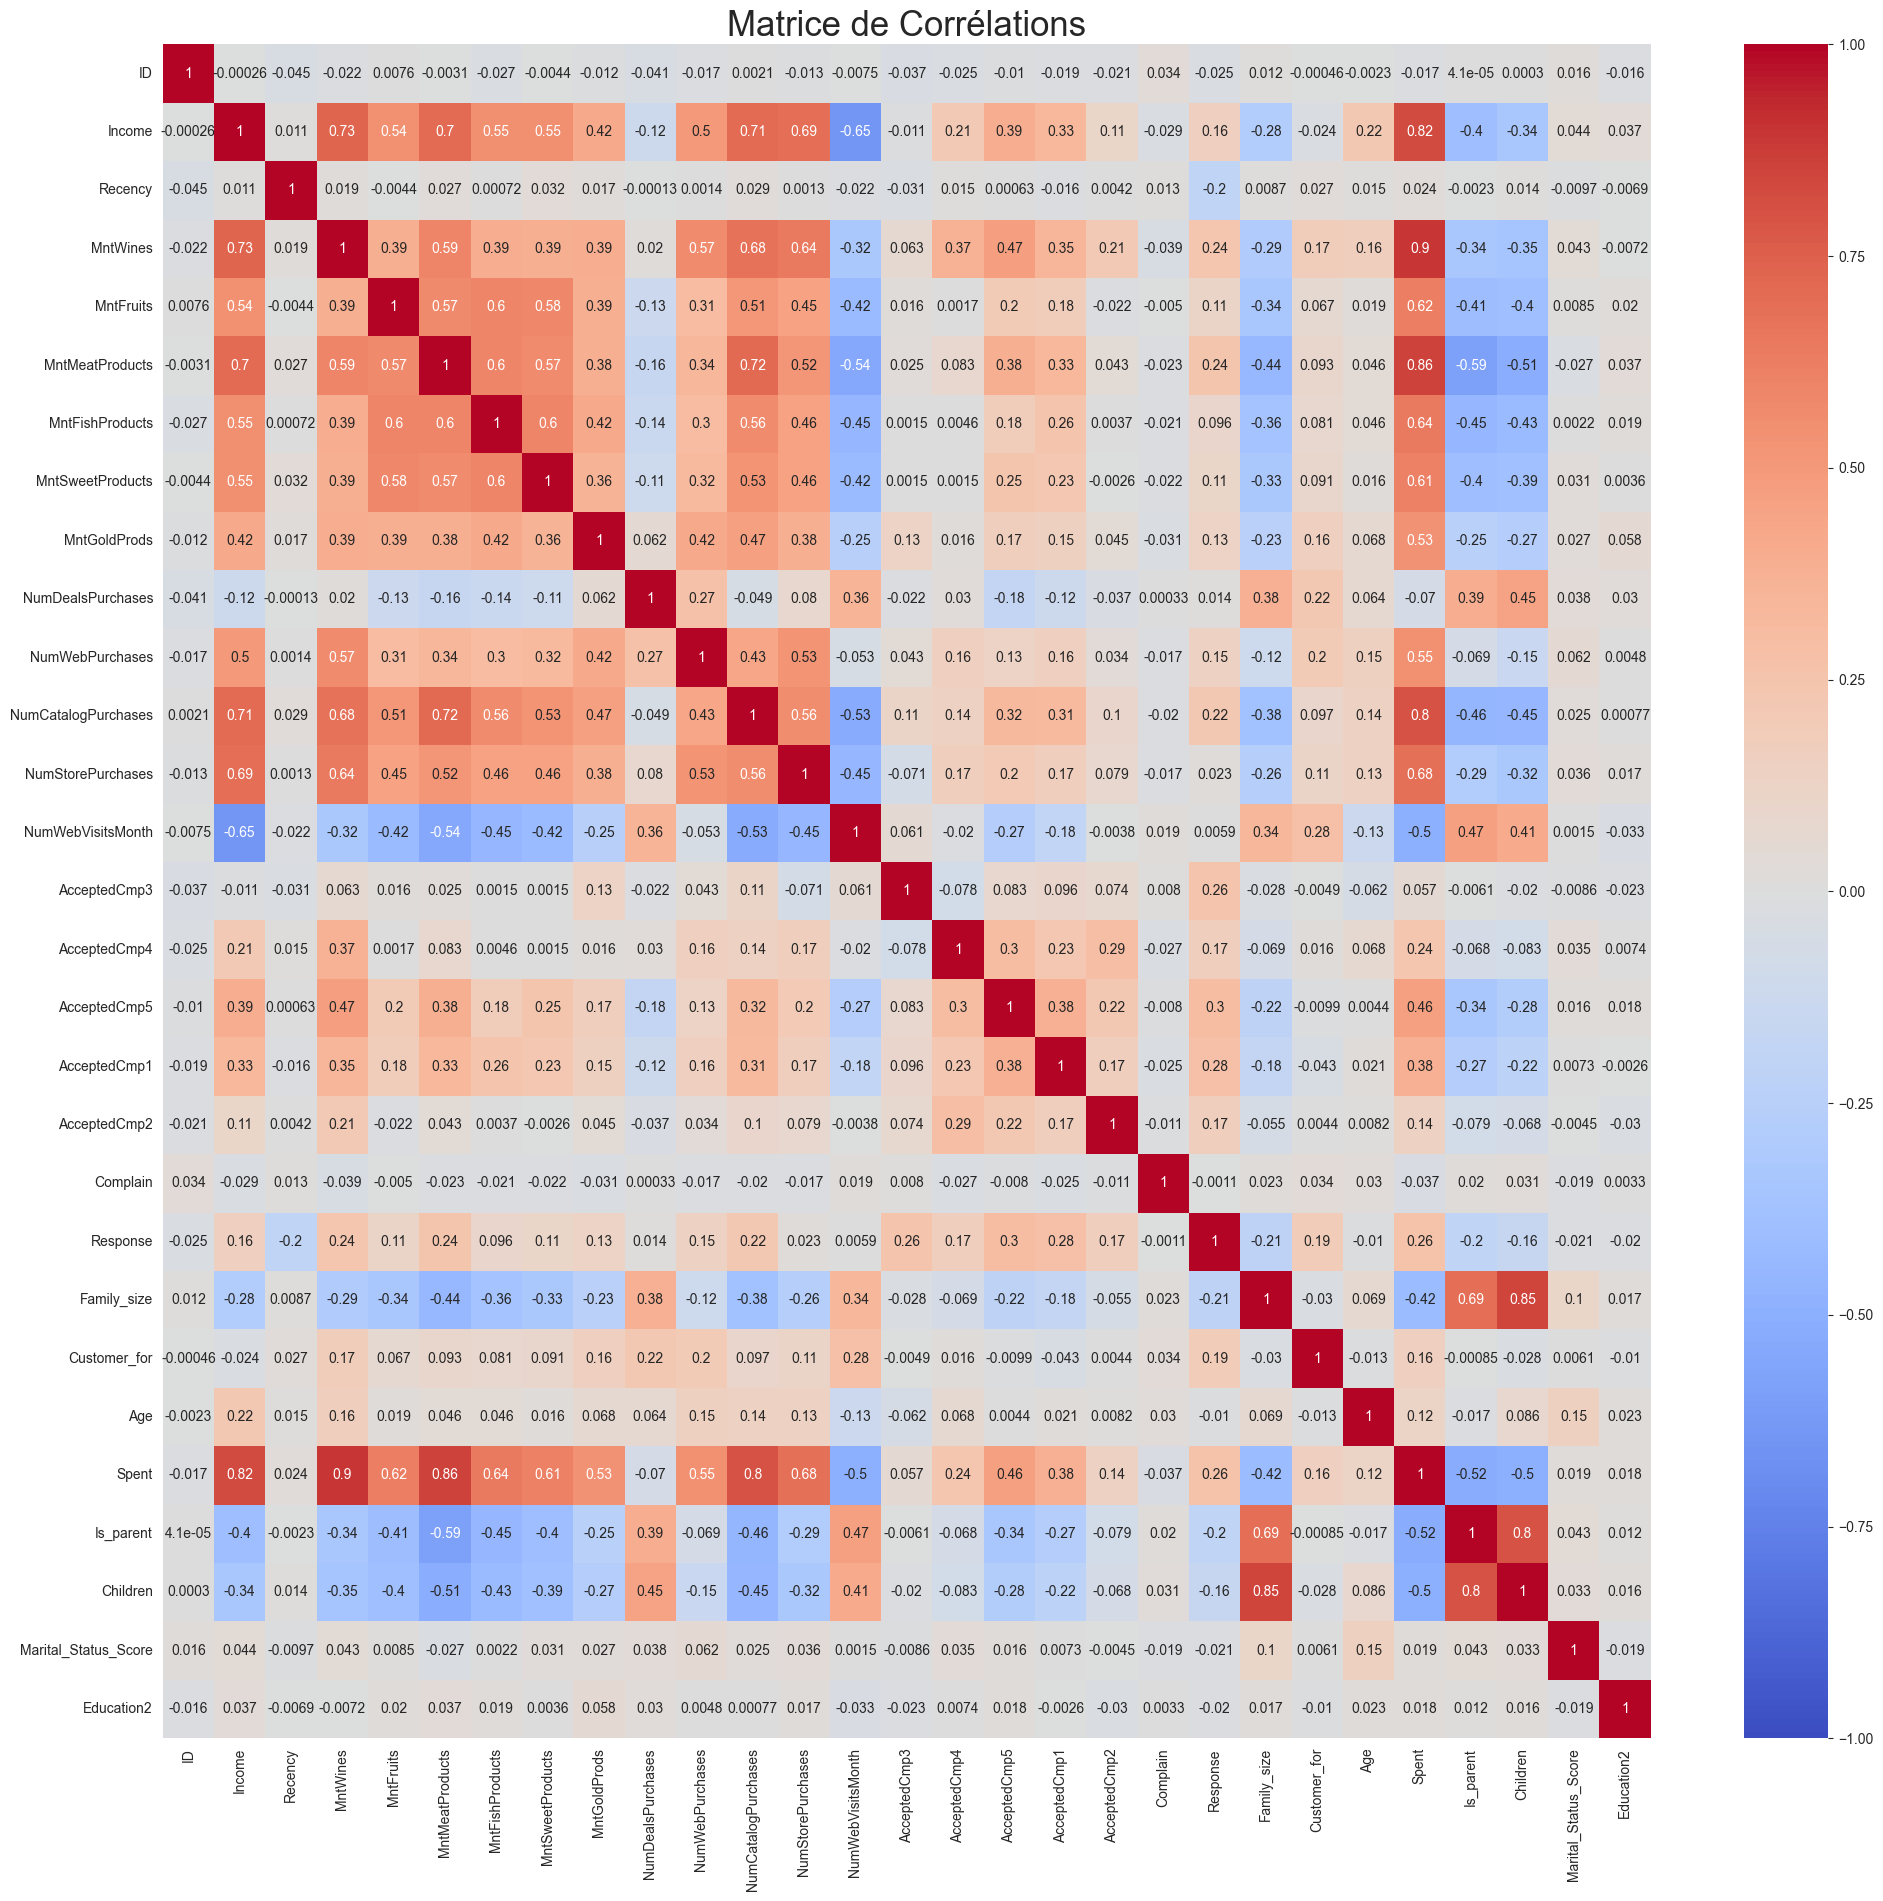

In [95]:
# Code
corr_matrix_encoded = data_encoded.corr()
plt.figure(figsize=(24, 22))
sns.heatmap(corr_matrix_encoded, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Matrice de Corrélations", fontsize=25)
plt.show()

Nous avons relevé les corrélations positives suivantes :

Naturellement, le montant dépensé et le revenu du client sont étroitement liés. Plus ses revenus sont élevés, plus un client va dépenser, et vice-versa. La matrice met également en avant que le montant total de viande achetée par un client a une plus grande proportionnalité avec le montant dépensé. Cela veut dire que plus le montant dépensé sera élevé, plus on a de chances de voir le nombre d’articles de viande être élevé. Cela peut s’expliquer par le fait que la viande fait partie des produits les plus chers. Globalement, nous avons observé que l’achat de viande est plus présent que les autres produits, cela fait partie des habitudes alimentaires des clients.


On observe également que les clients ont tendance à d’avantage acheter de produits depuis le catalogue que par un autre moyen (comme directement au magasin par exemple). Cela est mis à jour par la forte corrélation positive entre le nombre d’achats sur le catalogue et le montant dépensé (0.78). Ainsi, le catalogue utiliserait des moyens entraînant le client à acheter en plus grandes quantités, comme des pratiques marketing visant à augmenter le panier moyen (ex: promotions lors d'achats multiples du même article).

A l'inverse, on relève les corrélations négatives suivantes : 

La corrélation négative entre la taille de la famille et les dépenses (-0.42) met en lumière l'habitude des familles nombreuses à moins dépenser. Plus que moins dépenser, ces dernières font surtout plus attention au prix de leur panier. Ainsi les produit “haut de gamme” sont moins consommés par les familles. Cette théorie est fortement appuyée par la corrélation très négative entre le fait d'être parent et l'achat de viandes (-0.58). Etant donné que la viande fait partie des denrées les plus chères, on peut assumer de cette corrélation que les clients ayant des enfants vont moins dépenser pour acheter de la viande, mais plutôt consacrer leur budget pour d’autres produits. On peut affiner cette hypothèse avec la corrélation positive entre le nombre de visites en ligne par mois et la taille de la famille (0.33). Ils ont tendance à plus regarder les produits sur internet pour prévoir les futures dépenses et bénéficier de promotions.

A l'inverse, on observe une corrélation très négative entre le nombre de visites sur le site et les dépenses (-0,5). Cela veut dire que plus il y a de visites sur le site web, moins il y a de ventes en ligne et en magasin. Cette corrélation négative est aussi observée avec les produits haut de gamme. Nous pouvons en conclure que le site web dissuade les achats, ce qui peut être dû à des photos peu vendeuses sur le site ou un service en ligne qui n'est pas à la hauteur des attentes de la clientèle. Nous pouvons en conclure qu'une refonte du site est nécessaire, et qu’il doit plus mettre en avant les promotions disponibles, de par la corrélation positive (0.35) entre les achats via promotions et les visites sur le site.

# 3 - Analyse par K-Mean et segmentation clients
Les résultats de l'analyse exploratoire nous ont donnés des indications générales sur les tendances de consommation et la répartition de la clientèle. Pour affiner nos résultats et segmenter votre clientèle et cerner la cible client, nous sommes partis sur une analyse par `K-mean`:

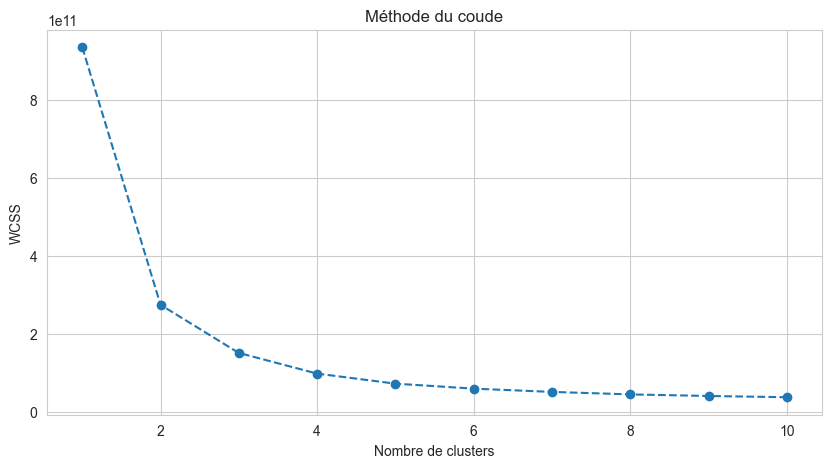

In [96]:
# PCA
pca = PCA(n_components=3)
data_scaled = pca.fit_transform(data_encoded)

# Application de KMeans avec 3 clusters
kmeans = KMeans(n_clusters=3, n_init=10, random_state=42)  # Ajout de n_init=10
clusters = kmeans.fit_predict(data_scaled)

# Méthode du coude
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', n_init=10, random_state=42)  # Ajout de n_init=10
    kmeans.fit(data_scaled)
    wcss.append(kmeans.inertia_)

# Visualisation de la méthode du coude
plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Méthode du coude')
plt.xlabel('Nombre de clusters')
plt.ylabel('WCSS')
plt.show()

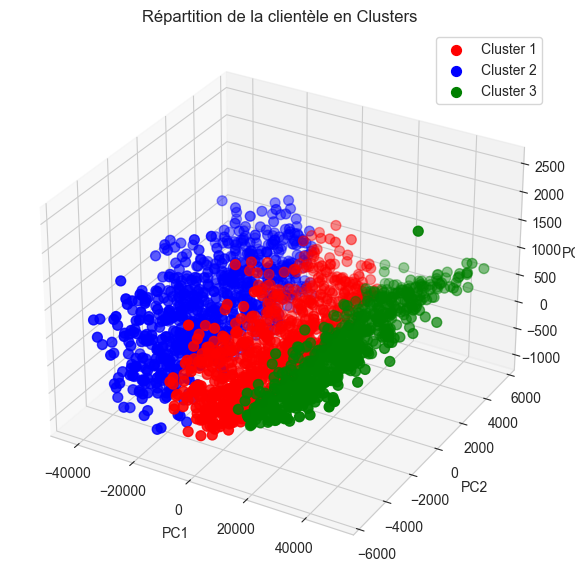

In [97]:
# Visualisation en 3D des clusters
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Assignation des couleurs aux clusters
colors = ['red', 'blue', 'green']
for i in range(3):
    ax.scatter(data_scaled[clusters == i, 0], data_scaled[clusters == i, 1], data_scaled[clusters == i, 2], 
               s=50, color=colors[i], label=f'Cluster {i+1}')

ax.set_title('Répartition de la clientèle en Clusters')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.legend()
plt.show()

Si nous analysons la répartition des clients en clusters du graphique précédent, on observe 3 groupes distincts :
- Le cluster bleu : Ces clients sont ceux qui dépensent le moins d’argent. Ce type de client a également globalement moins de revenus que les autres types, ce qui explique qu’il dépense moins. Cela pourrait être des économies pour subvenir aux besoins de leur famille, car ces clients sont ceux qui ont le plus d’enfants. On peut voir sur notre graphique que c’est le cluster le plus présent. Pour atteindre ce type de cible, il conviendrait ainsi de faire de campagnes marketing basées sur les produits type “familial” (grand formats, produits offerts si achat de masse,..).

- Le cluster vert : Ce type de client est celui qui a globalement le plus de revenus, et dépensant le plus d’argent dans nos produits. Ce sont ceux qui ont le moins d’enfants. Pour viser cette cible, il convient de mettre en avant les produits les moins cher individuels (conçus pour 1 personne).

- le cluster rouge : Ces clients sont situés entre les deux autres types de client, pouvant ainsi représenter notre client moyen. Ils n’ont globalement pas d’enfant et ont un revenu et une dépense régulières situés entre les deux autres types de client. Globalement, on pourrait suggérer qu’il s’agit de la classe haute de nos clients, qui n’ont pas beaucoup de membres dans leur famille mais un bon revenu et qui dépensent en conséquence. Pour faire une campagne marketing qui les cible, il conviendrait de mettre en avant les produits hauts de gamme.

Nous avons choisi d’utiliser la métrique `Silhouette Score` (SS) pour évaluer la qualité des clusters créés en termes de regroupement des échantillons avec d’autres échantillons similaires les uns aux autres. Ainsi, plus le score est élevé, meilleur est l’algorithme. Un bon SS indique qu’il est peu probable qu’un point de données soit attribué à un autre cluster.

Il est calculé de la manière suivante : 

In [98]:
score = silhouette_score(data_scaled, clusters)
print(score)

0.4979415862991675


Ici notre Silhouette Score est de 0.49. Nous pouvons expliquer ce score par le fait que nos trois clusters sont très rapprochés. Cela implique que le point de données se trouve proche de la limite de décision entre deux clusters.

Grâce à cette analyse en K-Mean, on peut donc en déduire que votre cible client sont des couples ou des personnes mariées sans enfants et avec des revenus conséquents.

# 4 - Résultats de la campagne marketing

Maintenant que notre analyse est terminée, statuons de l'efficacité de la campagne marketing. A partir de l'analyse des relations entre variables catégorielles et la réponse aux campagnes marketing, nous avons observé que les individus avec un niveau d'éducation en Bac +5 ou plus semblent avoir un taux de réponse plus élevé que les autres catégories. De plus, les individus mariés semblent être les plus réceptifs aux campagnes marketing.

#### A - Campagne marketing et temporalité

Rentrons maintenant plus dans le détails en prenant en compte la temporalité : 

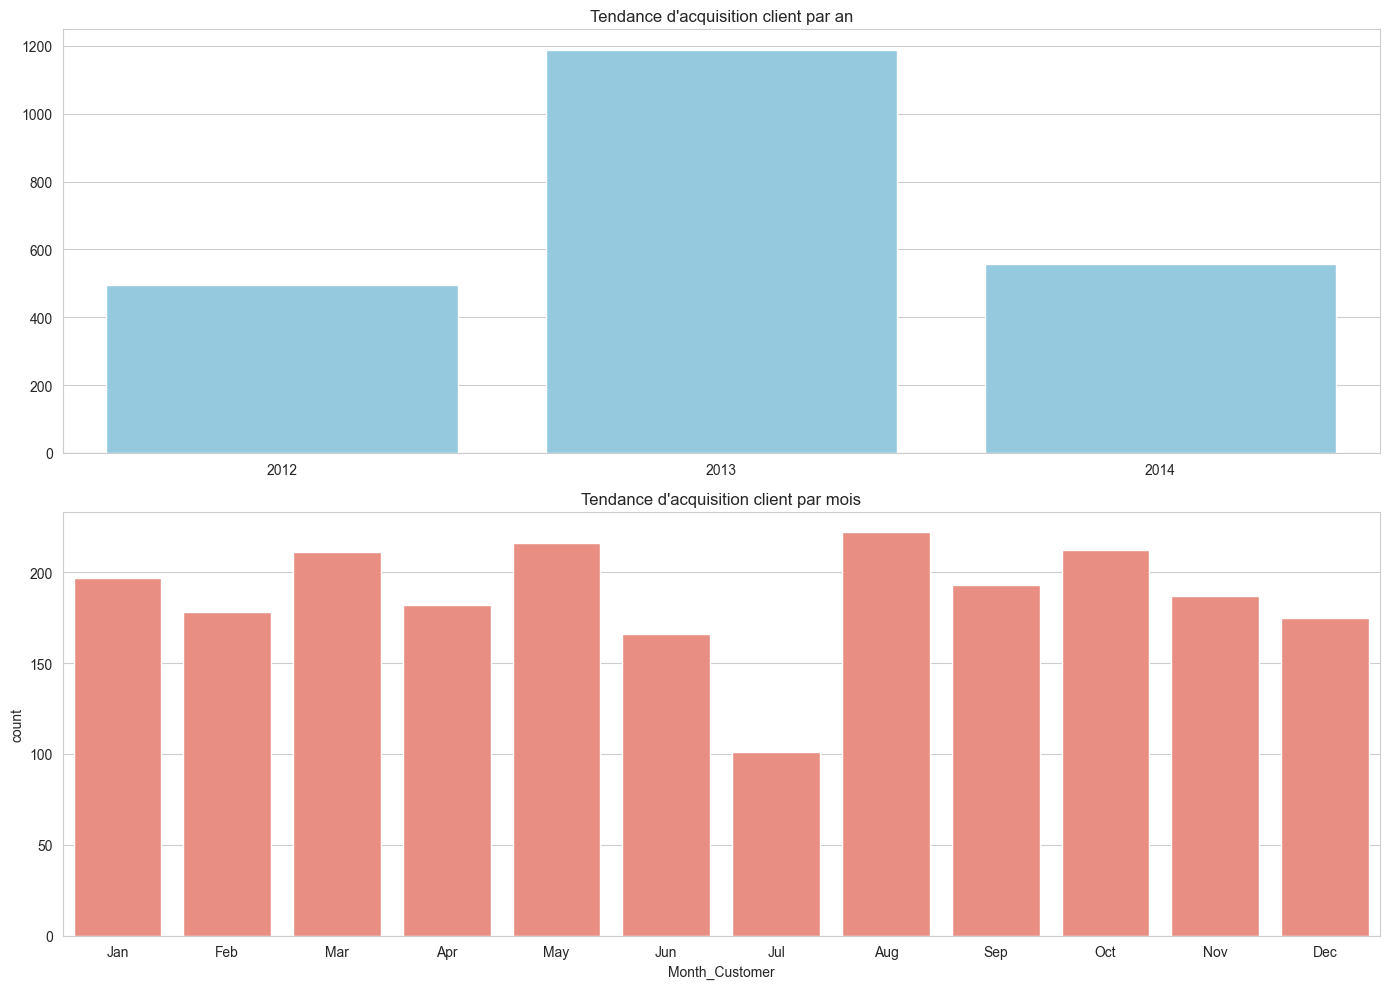

In [99]:
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'])
df['Year_Customer'] = df['Dt_Customer'].dt.year
df['Month_Customer'] = df['Dt_Customer'].dt.strftime('%b')

fig, axes = plt.subplots(2, 1, figsize=(14, 10))
sns.countplot(data=df, x='Year_Customer', ax=axes[0], color='skyblue')
axes[0].set_title('Tendance d\'acquisition client par an')
axes[0].set_ylabel('')
axes[0].set_xlabel('')

order_months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
sns.countplot(data=df, x='Month_Customer', ax=axes[1], color='salmon', order=order_months)
axes[1].set_title('Tendance d\'acquisition client par mois')
axes[0].set_ylabel('')
axes[0].set_xlabel('')

plt.tight_layout()
plt.show()

L'acquisition de clients semble relativement constante au fil des ans, avec une légère augmentation en 2013. Cela est dû en partie à des campagnes marketing réussies, mais cela a pu également être affecté par d'autres facteurs externes (comme l'expansion du marché par exemple). En regardant la tendance mensuelle, il semble que votre entreprise acquiert le plus de clients en août et septembre. Cela pourrait être lié à des campagnes saisonnières, des événements ou des promotions. Cela montre l'efficacité des campagnes marketings ciblées dans la temporalité. Nous vous conseillons donc d'en ajouter d'autres à des périodes de temps creuses pour rebooster le niveau général des ventes et l'acquisition de nouveaux clients.

#### B - Campagne marketing et durée de vie client

Intéressons nous plus à la durée de vie de nos clients, qui est calculée comme la différence entre la date actuelle et la date à laquelle le client a été acquis. Cette métrique est très utile pour comprendre comment les clients plus anciens diffèrent des clients plus récents en termes de comportement d'achat ou de réactivité aux campagnes marketing.

Au cours de notre analyse exploratoire, nous avons observé plusieurs phénomènes illustrés par les graphiques suivants :

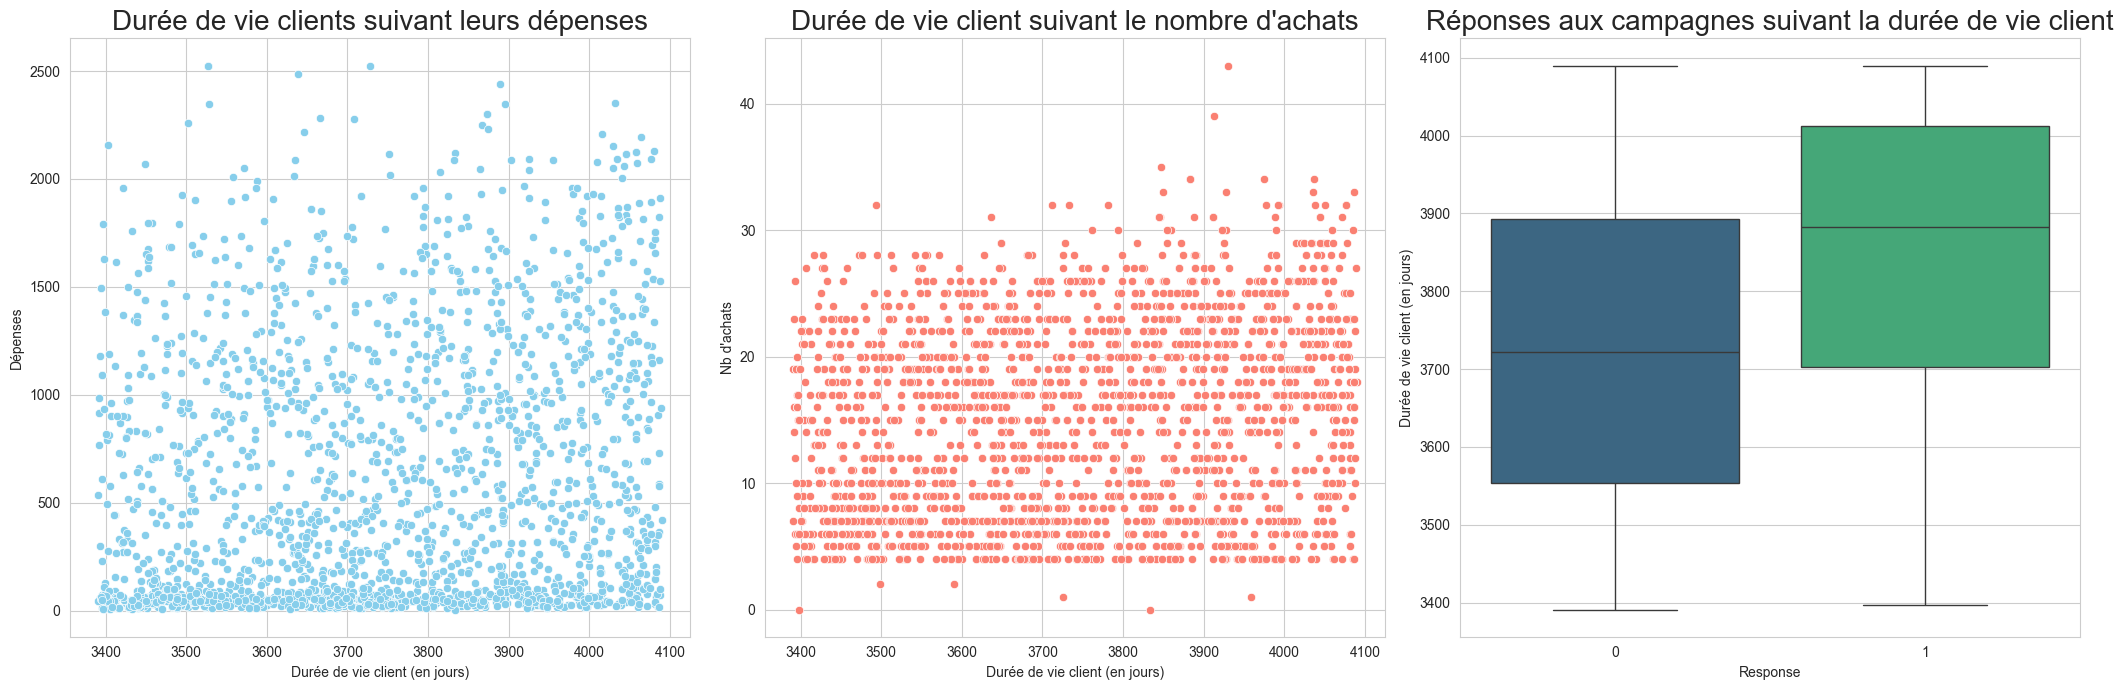

In [102]:
data_encoded['Customer_Lifetime'] = (pd.Timestamp.today() - df['Dt_Customer']).dt.days
data_encoded['Num_Purchases'] = df[['NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases']].sum(axis=1)
data_encoded['Total_Spent'] = data_encoded[['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']].sum(axis=1)

fig, axes = plt.subplots(1, 3, figsize=(21, 7))
sns.scatterplot(data=data_encoded, x='Customer_Lifetime', y='Total_Spent', ax=axes[0], color='skyblue')
axes[0].set_title('Durée de vie clients suivant leurs dépenses', fontsize=20)
axes[0].set_xlabel('Durée de vie client (en jours)')
axes[0].set_ylabel('Dépenses')

sns.scatterplot(data=data_encoded, x='Customer_Lifetime', y='Num_Purchases', ax=axes[1], color='salmon')
axes[1].set_title('Durée de vie client suivant le nombre d\'achats', fontsize=20)
axes[1].set_xlabel('Durée de vie client (en jours)')
axes[1].set_ylabel('Nb d\'achats')

sns.boxplot(data=data_encoded, x='Response', y='Customer_Lifetime', hue='Response', ax=axes[2], palette='viridis', legend=False)
axes[2].set_title('Réponses aux campagnes suivant la durée de vie client', fontsize=20)
axes[2].set_ylabel('Durée de vie client (en jours)')

plt.tight_layout()
plt.show()

Ainsi, on remarque que les clients plus anciens ne dépensent pas nécessairement plus que les clients plus récents. La taille du panier (en termes de quantité) subit les même observations. Cependant, les clients qui ont répondu aux campagnes ont tendance à rester plus longtemps client chez vous.

#### C - Campagne marketing et canaux d'achat

Examinons maintenant comment les préférences des canaux d'achat sont liées à la réponse aux campagnes marketing et à leur efficacité.

Vous avez trois canaux d'achat principaux : en magasin, en ligne et par catalogue. Les clients semblent préférer faire leurs achats en magasin, suivis des achats web et enfin sur catalogue. Les préférences de canal restent constantes à travers les différents niveaux d'éducation, bien que le volume d'achats varie. Nous pouvons donc en déduire que vos investissements en termes de campagnes marketing devront prendre en compte ces observations : vous devriez peut-être recentrer vos campagnes par le biai de canaux moins utilisés (comme en ligne par exemple) avec des avantages propres à chaque canal. Si l'on ne retrouve pas les mêmes promotions ou publicités en magasin et sur catalogue, cela incitera votre clientèle à ajouter à leurs préférences de canaux de nouveaux canaux.

Pour aller plus loin, voyons comment les réponses aux campagnes marketing individuelles sont liées aux préférences de canaux d'achat :

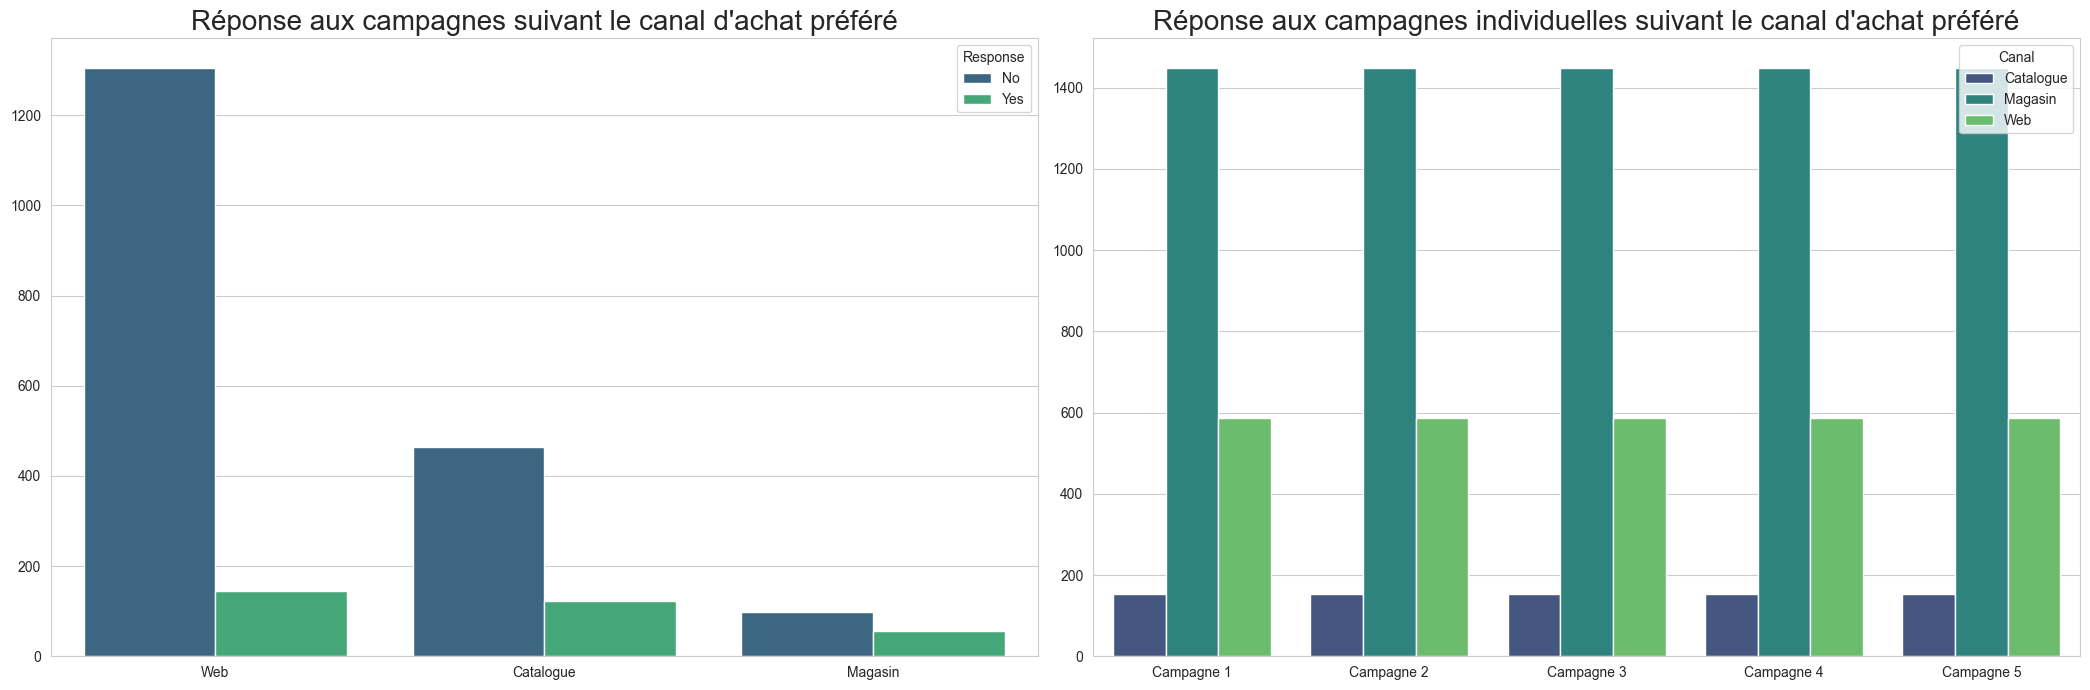

In [141]:
purchase_channels = ['NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases']
data_viz['Preferred_Channel'] = data_encoded[purchase_channels].idxmax(axis=1)
campaign_columns = ['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5']
new_campaign_names = ['Campagne 1', 'Campagne 2', 'Campagne 3', 'Campagne 4', 'Campagne 5']
df_melted_campaigns = data_viz.melt(id_vars='Preferred_Channel', value_vars=campaign_columns, var_name='Campaign', value_name='Response_Flag')
df_melted_campaigns['Campaign'] = df_melted_campaigns['Campaign'].replace(campaign_columns, new_campaign_names)

fig, axes = plt.subplots(1, 2, figsize=(21, 7))

# Graphique 1 : Réponse aux campagnes suivant le canal d'achat préféré
plt.sca(axes[0])
sns.countplot(data=data_viz, x='Preferred_Channel', hue='Response', palette='viridis',
              order=data_viz['Preferred_Channel'].value_counts().index)
plt.title('Réponse aux campagnes suivant le canal d\'achat préféré', fontsize=20)
plt.xlabel('')
plt.ylabel('')
plt.legend(title='Response', labels=['No', 'Yes'])
plt.xticks(ticks=range(3), labels=['Web', 'Catalogue', 'Magasin'])

# Graphique 2 : Réponse aux campagnes individuelles suivant le canal d'achat préféré
plt.sca(axes[1])
sns.countplot(data=df_melted_campaigns, x='Campaign', hue='Preferred_Channel', palette='viridis')
plt.title('Réponse aux campagnes individuelles suivant le canal d\'achat préféré', fontsize=20)
plt.xlabel('')
plt.ylabel('')
plt.legend(title='Canal', labels=['Catalogue', 'Magasin', 'Web'])

plt.tight_layout()
plt.show()

On observe ainsi que les clients privilégiant les achats en ligne ont le taux de réponse le plus élevé aux campagnes marketing. A l'inverse, les clients qui privilégient les achats en magasin ont un taux de réponse inférieur. Cette tendance est validée sur l'ensemble des campagnes recensées dans notre jeu de données.

Le test du Chi-Carré nous a permis de vérifier s'il existe une association statistiquement significative entre le canal d'achat préféré et :
1. La réponse globale aux campagnes marketing `Response`.
2. La réponse à la dernière campagne marketing `AcceptedCmp1`.

In [135]:
# Calcul du Chi-Carré pour la réponse aux campagnes suivant le canal préféré
value = 8.25 * pow(10, -22)
print("Valeur de Chi-Carré pour toutes les campagnes :", value)

# Calcul du Chi-Carré pour la réponse à la dernière campagne suivant le canal préféré
chi_value = 4.48 * pow(10, -17)
print("Valeur de Chi-Carré pour la dernière campagne : ", chi_value)

Valeur de Chi-Carré pour toutes les campagnes : 8.25e-22
Valeur de Chi-Carré pour la dernière campagne :  4.480000000000001e-17


La valeur est très inférieure au seuil de signification généralement accepté de 0.05, indiquant qu'il existe une association statistiquement significative entre le canal d'achat préféré et la réponse aux campagnes marketing. Le même phénomène est observé pour la réponse à la dernière campagne.

Ces tests statistiques ont donc démontré que les différences observées dans les réponses aux campagnes marketing selon le canal d'achat préféré ne sont pas dues au hasard et sont statistiquement significatives. Les préférences des canaux d'achat sont donc liées de manière importante à la manière dont les clients réagissent aux campagnes marketing.

Nous vous conseillons donc d'adopter des campagnes marketing différentes suivant le canal d'achat et le client type qui utilise ce canal.

A ASSOCIER A LANALYSE PAR CLUSTER DES AUTRES